In [9]:
# made by Gibeom LEE, HI LAB
# 한 폴더 내 모든 csv 파일의 TENG Vpp값을 구할 때 유용합니다.
# +250806 각 frequency도 같이 보여줍니다.

In [10]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt # Matplotlib import 추가

In [11]:
# ================= 사용자 설정 =================
# 폴더 경로
folder_path = r"C:\Users\user\Desktop\Drive파일\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\4. Data measurement\251105_내구도 실험 잘됨\Figure 4i"

# 사용자 설정값 (피크 탐지 기준)
prominence_ratio = 0.3 # 신호의 표준편차(std)에 곱해 피크 prominence 기준을 설정
min_prominence = 0.1   # prominence의 최솟값 제한
min_distance_sec = 0.1 # 인접한 피크 간 최소 시간 간격 (초 단위)
snr_threshold = 1      # Signal-to-Noise Ratio 기준값
min_relative_height = 0.01 # 전체 최대 진폭 설정 (ex: 0.2는 20% 이상)

# 그래프 설정
y_range = (-150, 20) # (None, None) 또는 (-70, 5)와 같이 지정
y_range = (None, None)

--- 1. PDMS - Ch1 결과 ---
평균 Vpp: 114.25 V, 피크 수: 7개, Vpp 표준편차: 3.60 V, 평균 주파수: 8.55 Hz


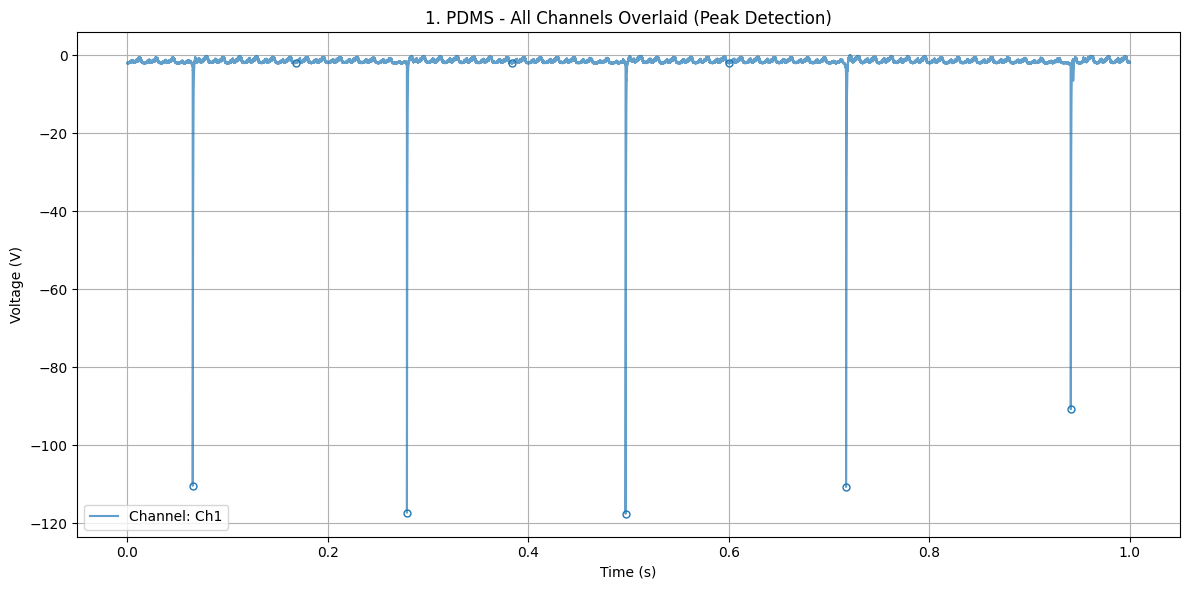

--- 2. OTS - Ch1 결과 ---
평균 Vpp: 61.70 V, 피크 수: 7개, Vpp 표준편차: 9.10 V, 평균 주파수: 8.13 Hz


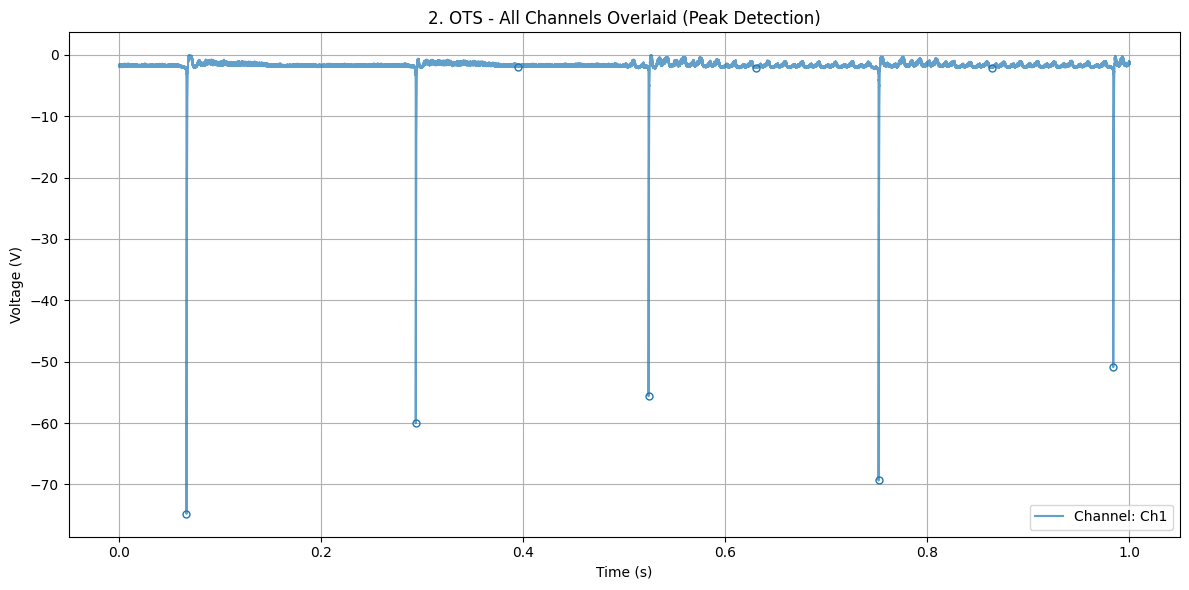

--- 3. Squalane - Ch1 결과 ---
평균 Vpp: 44.02 V, 피크 수: 4개, Vpp 표준편차: 1.42 V, 평균 주파수: 4.09 Hz


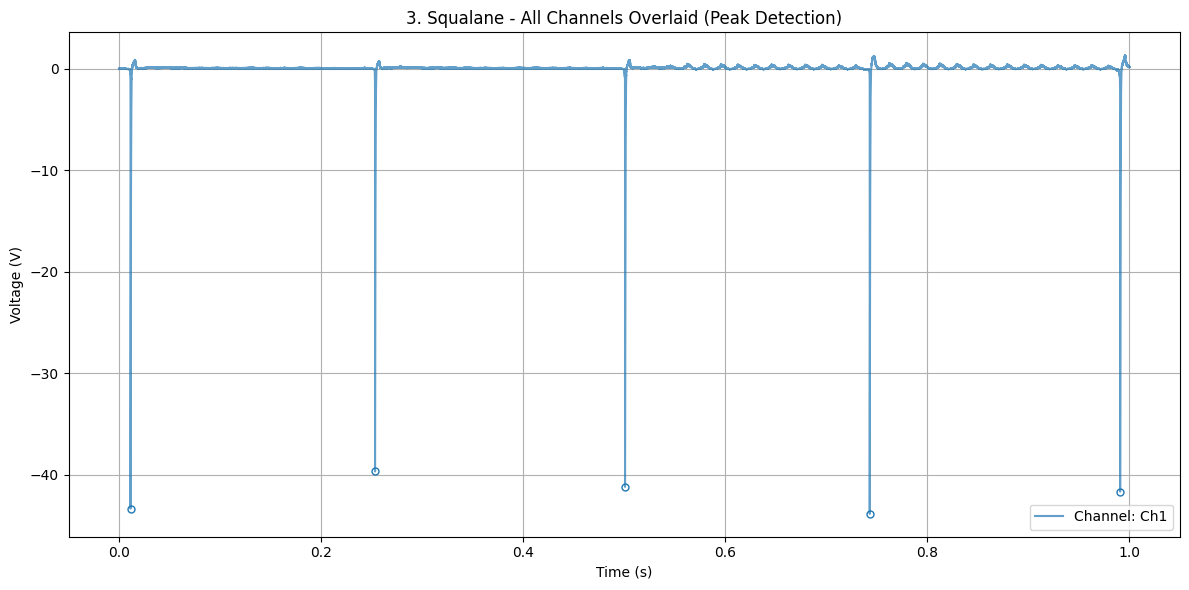

--- 4. OTS-squalane - Ch1 결과 ---
평균 Vpp: 87.26 V, 피크 수: 8개, Vpp 표준편차: 13.57 V, 평균 주파수: 9.11 Hz


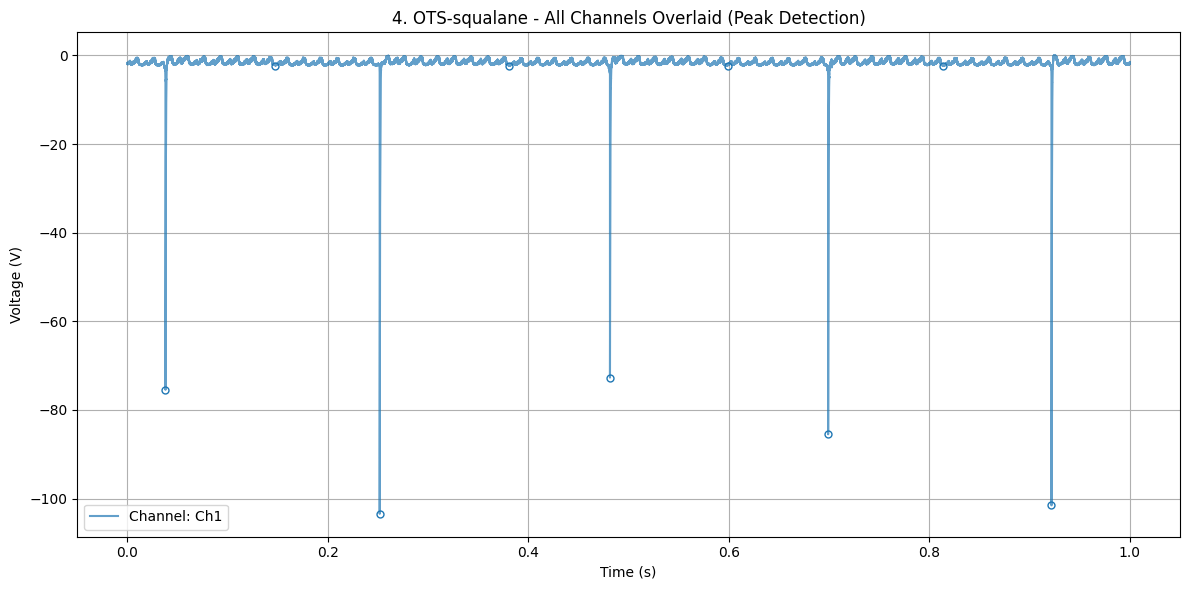

경고: Figure 4i_merge.csv 파일은 결측치 제거 후 유효한 데이터가 없습니다.

📊 전체 분석 요약
| File            | Channel   |   Avg Vpp (V) |   Std Dev (Vpp) |   Avg Freq (Hz) |   Std Dev (Freq) |   Peak Count |
|:----------------|:----------|--------------:|----------------:|----------------:|-----------------:|-------------:|
| 1. PDMS         | Ch1       |        114.25 |            3.6  |            8.55 |             1.86 |            7 |
| 2. OTS          | Ch1       |         61.7  |            9.1  |            8.13 |             1.79 |            7 |
| 3. Squalane     | Ch1       |         44.02 |            1.42 |            4.09 |             0.05 |            4 |
| 4. OTS-squalane | Ch1       |         87.26 |           13.57 |            9.11 |             0.76 |            8 |

📈 전체 데이터셋 종합 평균
 전체 평균 Vpp: 76.81 V
 전체 평균 주파수: 7.47 Hz


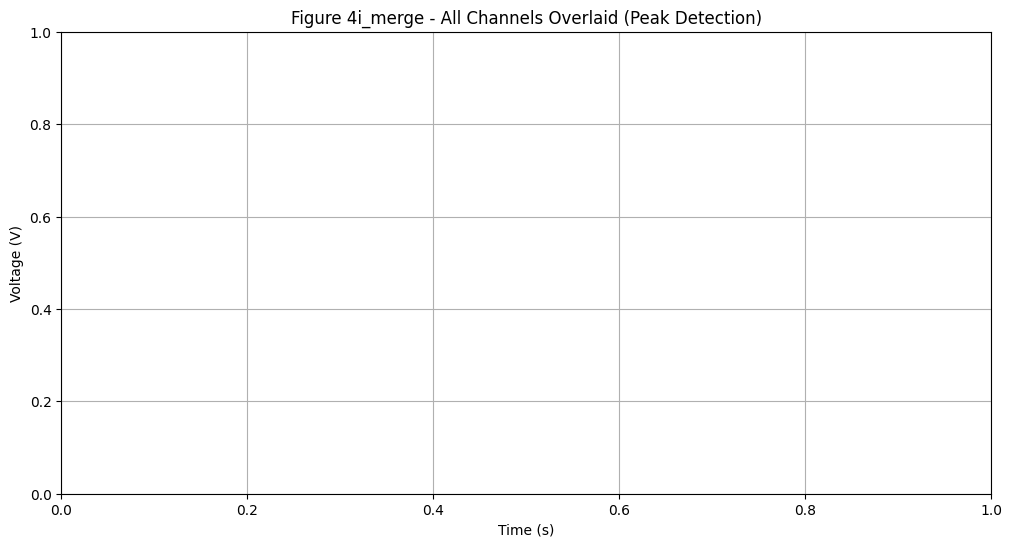

In [12]:
# ================= 변수 초기화 =================
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
all_results = {} # 모든 파일/채널의 결과를 저장할 딕셔너리
# ------------------------------------------------

# -------------------------------
# 파일별 처리
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    base_name = os.path.splitext(file_name)[0]
    
    file_results = {} 
    
    # 그래프를 그릴 준비 (파일당 1개)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"{base_name} - All Channels Overlaid (Peak Detection)")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V)")
    ax.grid(True)


    try:
        # 1. 데이터 로드 (모든 열 로드)
        df = pd.read_csv(file_path, skiprows = 30)
        
        # 🚨 [수정 1] 데이터 정리: 문자열을 숫자로 변환하며 발생한 NaN (결측치)이 포함된 행을 제거
        # Time 열은 0열이므로, 1열부터 끝까지의 데이터에 NaN이 있는지 확인
        # NaN이 포함된 행을 모두 제거합니다. (dropna 사용)
        df = df.dropna(how='any') 
        
        # 만약 전체 파일에서 첫 행/끝 행의 시간 데이터만 필요하다면, 아래로직 추가
        if df.empty:
            print(f"경고: {file_name} 파일은 결측치 제거 후 유효한 데이터가 없습니다.")
            continue # 다음 파일로 넘어감

        time = df.iloc[:, 0].values
        voltage_data = df.iloc[:, 1:].values
        
        # 이전 헤더 이름 대신 순번(1부터 시작)으로 채널 이름 생성 (Ch1, Ch2, Ch3, ...)
        channel_names = [f"Ch{i+1}" for i in range(voltage_data.shape[1])]
        
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)
        
        # 2. 채널별 처리 및 그래프 중첩
        for col_idx, channel_name in enumerate(channel_names): # channel_name이 이제 Ch1, Ch2...
            voltage = voltage_data[:, col_idx] # 현재 채널의 전압 데이터
            
            # --------------------- 분석 시작 ---------------------
            
            # 2.1. 피크 검출
            prom = max(np.std(voltage) * prominence_ratio, min_prominence)
            raw_peaks, properties = find_peaks(-voltage, prominence=prom, distance=distance)

            # 2.2. 피크 필터링 (SNR 및 상대 높이)
            max_amplitude = np.max(-voltage)
            final_peaks = []
            noise_segment_size = int(0.05 * sampling_rate)

            for i in raw_peaks:
                left = max(0, i - noise_segment_size)
                right = min(len(voltage), i + noise_segment_size)
                local_noise = max(np.std(voltage[left:right]), 1e-6) 
                signal = -voltage[i] 
                
                condition_height = signal > max_amplitude * min_relative_height
                condition_snr = signal / local_noise > snr_threshold
                
                if condition_height and condition_snr:
                    final_peaks.append(i)

            final_peaks = np.array(final_peaks, dtype=int)
            peak_times = time[final_peaks]

            # 2.3. Vpp 및 표준편차, 주파수 계산
            vpp_list = []
            num_vpp = 0
            if len(final_peaks) >= 2:
                for i in range(len(final_peaks) - 1):
                    start = final_peaks[i]
                    end = final_peaks[i + 1]
                    vpp = np.max(voltage[start:end + 1]) - np.min(voltage[start:end + 1])
                    vpp_list.append(vpp)
                num_vpp = len(vpp_list)
            elif len(final_peaks) == 1:
                vpp_list.append(np.max(voltage) - np.min(voltage))
                num_vpp = 1
            
            mean_vpp = np.mean(vpp_list) if vpp_list else 0
            std_vpp = np.std(vpp_list, ddof=1) if len(vpp_list) > 1 else 0

            if len(peak_times) >= 2:
                periods = np.diff(peak_times)
                mean_freq = np.mean(1 / periods)
                std_freq = np.std(1 / periods, ddof=1) if len(periods) > 1 else 0
            else:
                mean_freq = 0
                std_freq = 0
                
            # --------------------- 분석 완료 ---------------------
            
            # 3. 결과 출력 및 저장
            # 채널 이름이 Ch1, Ch2...로 출력됩니다.
            print(f"--- {base_name} - {channel_name} 결과 ---")
            print(f"평균 Vpp: {mean_vpp:.2f} V, 피크 수: {num_vpp:.0f}개, Vpp 표준편차: {std_vpp:.2f} V, 평균 주파수: {mean_freq:.2f} Hz")
            
            file_results[channel_name] = {
                'Vpp': mean_vpp, 'Vpp_std': std_vpp, 
                'Freq': mean_freq, 'Freq_std': std_freq,
                'Peak_count': num_vpp
            }
            
            # 4. 그래프 중첩
            ax.plot(time, voltage, label=f'Channel: {channel_name}', alpha=0.7) 
            
            if len(final_peaks) > 0:
                ax.plot(time[final_peaks], voltage[final_peaks], 'o', 
                        markerfacecolor='none', markeredgecolor=ax.lines[-1].get_color(), 
                        markersize=5, linestyle='none')
                
        # 5. 파일별 그래프 마무리 및 표시
        if y_range[0] is not None and y_range[1] is not None:
            ax.set_ylim(y_range)
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()

        all_results[file_name] = file_results
            
    except Exception as e:
        print(f"[{file_name}] 파일 처리 중 오류 발생: {e}")
        print("CSV 파일의 형식이 1열 시간, 나머지 전압 데이터인지 확인하십시오.")

# -------------------------------
# 전체 요약 출력 (이전 코드와 동일)
print("\n======================================")
print("📊 전체 분석 요약")
print("======================================")

summary_data = []
for file_name, channels in all_results.items():
    base_name = os.path.splitext(file_name)[0]
    for channel_name, data in channels.items():
        summary_data.append({
            'File': base_name,
            'Channel': channel_name,
            'Avg Vpp (V)': f"{data['Vpp']:.2f}",
            'Std Dev (Vpp)': f"{data['Vpp_std']:.2f}",
            'Avg Freq (Hz)': f"{data['Freq']:.2f}",
            'Std Dev (Freq)': f"{data['Freq_std']:.2f}",
            'Peak Count': data['Peak_count']
        })

summary_df = pd.DataFrame(summary_data)
if not summary_df.empty:
    try:
        # tabulate이 설치되어 있다면 마크다운 테이블 출력
        print(summary_df.to_markdown(index=False)) 
    except ImportError:
        # 설치되어 있지 않다면 일반 출력
        print(summary_df.to_string(index=False))
else:
    print("📭 처리된 데이터가 없습니다.")

if summary_data:
    all_vpp = [float(d['Avg Vpp (V)']) for d in summary_data]
    all_freq = [float(d['Avg Freq (Hz)']) for d in summary_data]
    
    overall_mean_vpp = np.mean(all_vpp)
    overall_mean_freq = np.mean(all_freq)
    
    print("\n======================================")
    print("📈 전체 데이터셋 종합 평균")
    print(f" 전체 평균 Vpp: {overall_mean_vpp:.2f} V")
    print(f" 전체 평균 주파수: {overall_mean_freq:.2f} Hz")
    print("======================================")